# Exploratory analysis of the Eurovision 2018 votes Dataset


In this notebook we will try to explore and visualize eurovision 2018 votes dataset as a network, using ``networkx`` package

Start with imports

In [1]:
import sys
!{sys.executable} -m pip install colorthief

In [34]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
from itertools import chain
import tqdm as tqdm
from colorthief import ColorThief

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

We'll load the Eurovision 2018 votes dataset from: https://eurovision.tv/story/the-results-eurovision-2018-dive-into-numbers

In [3]:
votes_data = pd.read_excel('ESC2018_GF.xlsx', header=1, sheet_name='Combined result')

In [4]:
print(votes_data.shape)
votes_data.head(5)

(26, 47)


,Rank,Running order,Country,Total,Albania,Austria,Belarus,Belgium,Croatia,Cyprus,...,Hungary,Moldova,Armenia,Czech Republic,Georgia,Montenegro,Azerbaijan,San Marino,Italy,Australia
0,1,22,Israel,529,6,19,8,16,16,10,...,16,22,18,22,15,1,13,24,9,18
1,2,25,Cyprus,436,20,1,15,11,8,0,...,7,13,19,8,10,6,14,7,8,7
2,3,5,Austria,342,2,0,10,15,0,2,...,11,3,7,5,9,0,0,0,7,5
3,4,11,Germany,340,14,16,0,7,3,3,...,1,8,5,3,7,0,5,14,13,12
4,5,26,Italy,308,24,10,4,6,10,15,...,6,8,3,2,5,12,5,12,0,0


In [5]:
votes_data.tail(5)

,Rank,Running order,Country,Total,Albania,Austria,Belarus,Belgium,Croatia,Cyprus,...,Hungary,Moldova,Armenia,Czech Republic,Georgia,Montenegro,Azerbaijan,San Marino,Italy,Australia
21,22,3,Slovenia,64,0,5,4,0,7,0,...,0,0,0,7,0,6,0,6,0,0
22,23,2,Spain,61,0,0,0,1,0,7,...,0,0,0,0,0,0,0,0,0,7
23,24,9,United Kingdom,48,3,0,0,0,2,0,...,0,0,0,0,0,2,0,1,6,6
24,25,17,Finland,46,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,4
25,26,8,Portugal,39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the `votes_data` dataframe we have the information of number of points each country recieved from other countries. We'll tranform in into edge-list of votes with ``melt`` transformation

In [6]:
votes_melted = votes_data.melt(
    ['Rank','Running order','Country','Total'],
    var_name = 'Source Country',value_name='points')

In [7]:
votes_melted.head()

,Rank,Running order,Country,Total,Source Country,points
0,1,22,Israel,529,Albania,6
1,2,25,Cyprus,436,Albania,20
2,3,5,Austria,342,Albania,2
3,4,11,Germany,340,Albania,14
4,5,26,Italy,308,Albania,24


Let's build a directed, weighted ``networkx`` graph from the edgelist in ``votes_melted``:

In [8]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())

In [9]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 43
Number of edges: 1118
Average in degree:  26.0000
Average out degree:  26.0000


And let's visualize it:

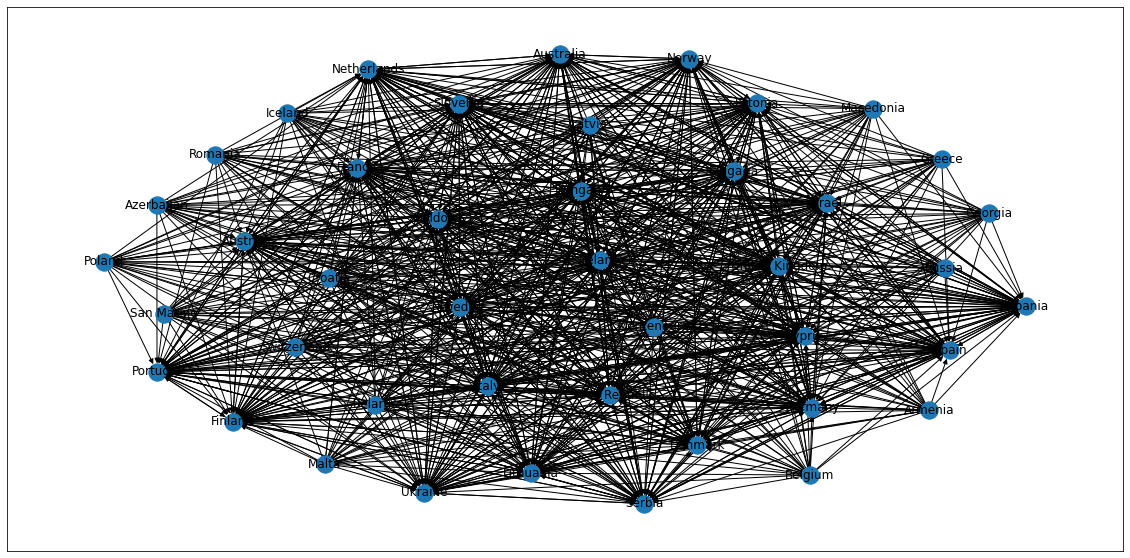

In [10]:
nx.draw_networkx(G)

Every country is giving the same amount of points (out degree):

In [11]:
G.out_degree(weight='points')

OutDegreeView({'Albania': 116, 'Israel': 116, 'Cyprus': 116, 'Austria': 116, 'Germany': 116, 'Italy': 116, 'Czech Republic': 116, 'Sweden': 116, 'Estonia': 116, 'Denmark': 116, 'Moldova': 116, 'Lithuania': 116, 'France': 116, 'Bulgaria': 116, 'Norway': 116, 'Ireland': 116, 'Ukraine': 116, 'Netherlands': 116, 'Serbia': 116, 'Australia': 116, 'Hungary': 116, 'Slovenia': 116, 'Spain': 116, 'United Kingdom': 116, 'Finland': 116, 'Portugal': 116, 'Belarus': 116, 'Belgium': 116, 'Croatia': 116, 'Macedonia': 116, 'Greece': 116, 'Iceland': 116, 'Latvia': 116, 'Malta': 116, 'Poland': 116, 'Romania': 116, 'Russia': 116, 'Switzerland': 116, 'Armenia': 116, 'Georgia': 116, 'Montenegro': 116, 'Azerbaijan': 116, 'San Marino': 116})

In [12]:
Gsub = G.edge_subgraph([(e[0],e[1]) for e in G.edges(data=True) if e[2]['points']>0])

(array([16.,  1.,  3.,  2.,  3.,  5.,  4.,  1.,  4.,  4.]),
 array([13. , 17.5, 22. , 26.5, 31. , 35.5, 40. , 44.5, 49. , 53.5, 58. ]),
 <BarContainer object of 10 artists>)

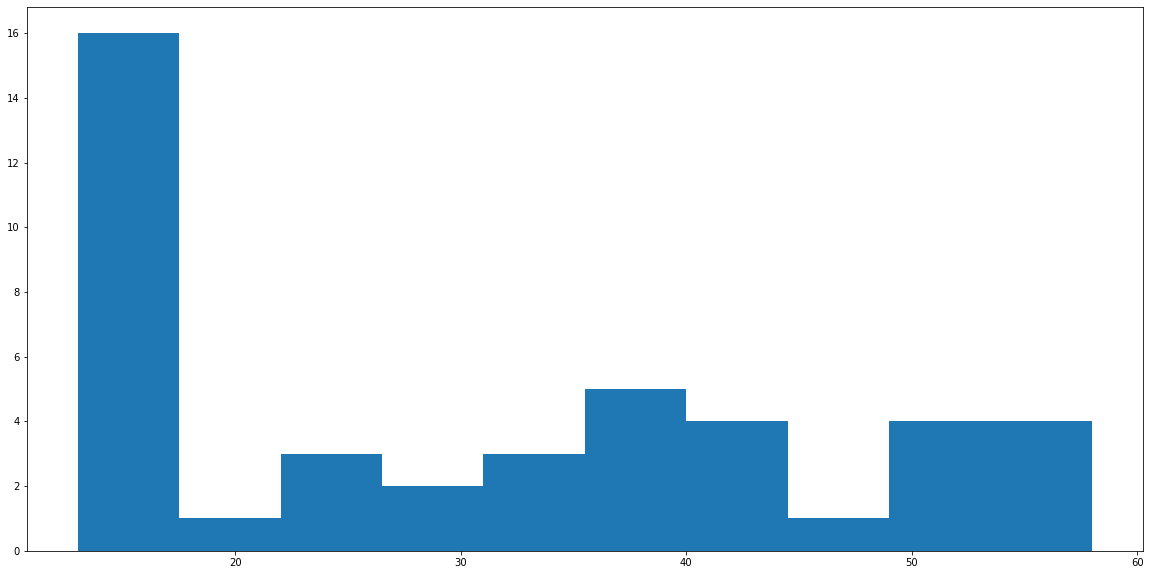

In [16]:
plt.hist(dict(Gsub.degree()).values())

### However in degree is the one that determines the victory: 

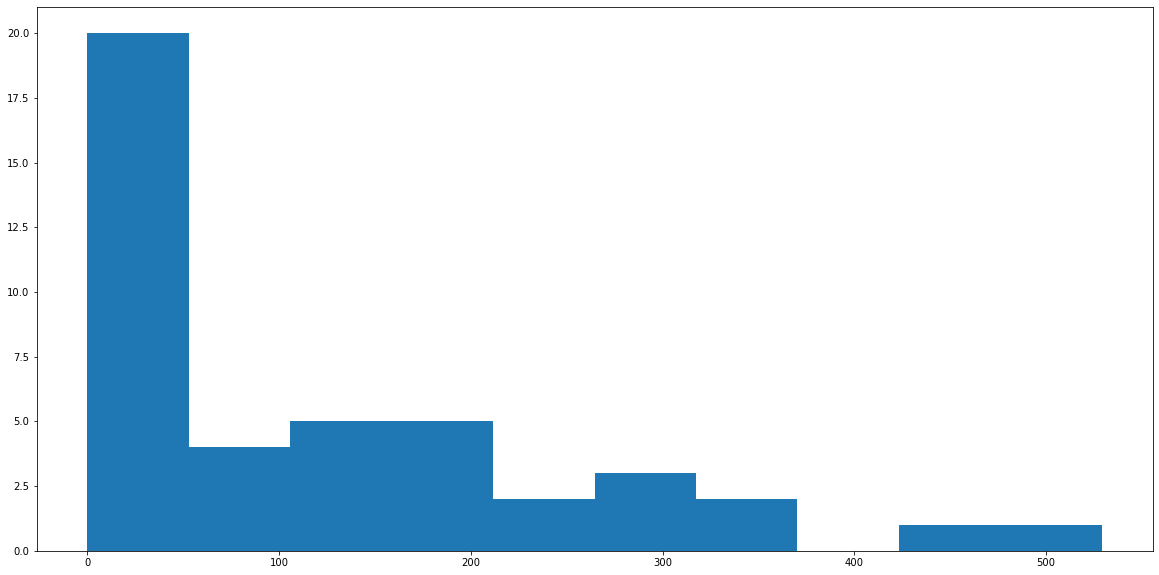

In [17]:
h = plt.hist(dict(G.in_degree(weight='points')).values())

In [18]:
deg_cen_points = dict(G.in_degree(weight='points'))
{k:deg_cen_points[k] for k in deg_cen_points if deg_cen_points[k]==max(deg_cen_points.values())}

{'Israel': 529}

In [19]:
page_rank = dict(nx.pagerank_numpy(G,weight='points'))
{k:page_rank[k] for k in page_rank if page_rank[k]==max(page_rank.values())}

{'Israel': 0.09068710831987256}

In [20]:
between = dict(nx.betweenness_centrality(G,weight='points'))
{k:between[k] for k in between if between[k]==max(between.values())}

{'Estonia': 46701.144689294066}

Let's assign to each coutry it's flag and position of the map

In [22]:
countries = pd.read_csv('countries.csv',index_col='Country')

In [23]:
countries.head()

,cc2,cc3,numeric,latitude,longitude
Country,,,,,
Afghanistan,AF,AFG,4,33.0000,65.0
Albania,AL,ALB,8,41.0000,20.0
Algeria,DZ,DZA,12,28.0000,3.0
American Samoa,AS,ASM,16,-14.3333,-170.0
Andorra,AD,AND,20,42.5000,1.6


In [24]:
pos_geo = {  node: 
           ( max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
             max(countries.loc[node]['latitude'],25)) #fixing scale
               for node in G.nodes() }

In [25]:
pos_geo = {}
for node in G.nodes():
    pos_geo[node] = (
                    max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
                    max(countries.loc[node]['latitude'],25) #fixing scale
    )

In [28]:
flags = {}
flag_color = {}
for node in tqdm.tqdm_notebook(G.nodes()):
    flags[node] = 'flags/'+(countries.loc[node]['cc3']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)

  0%|          | 0/43 [00:00<?, ?it/s]

In [29]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

Now we will draw all the parts one-by-one

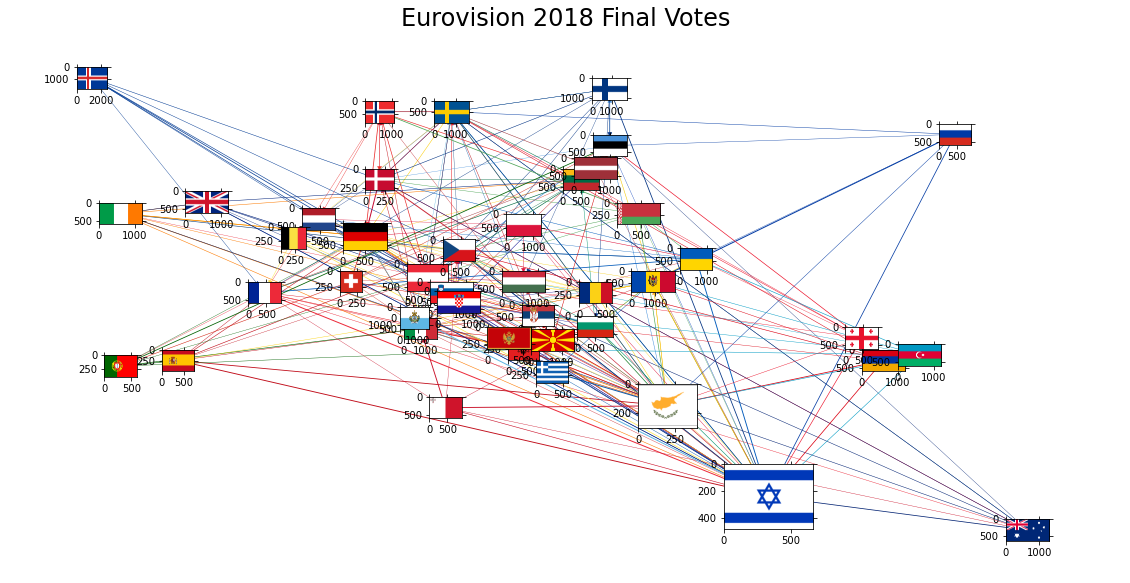

In [31]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params

styles = ['dotted','dashdot','dashed','solid'] # line styles

pos = pos_geo
    
# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.3: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():      
    imsize = max((0.3*G.in_degree(node,weight='points')
                  /max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_map.png')
    

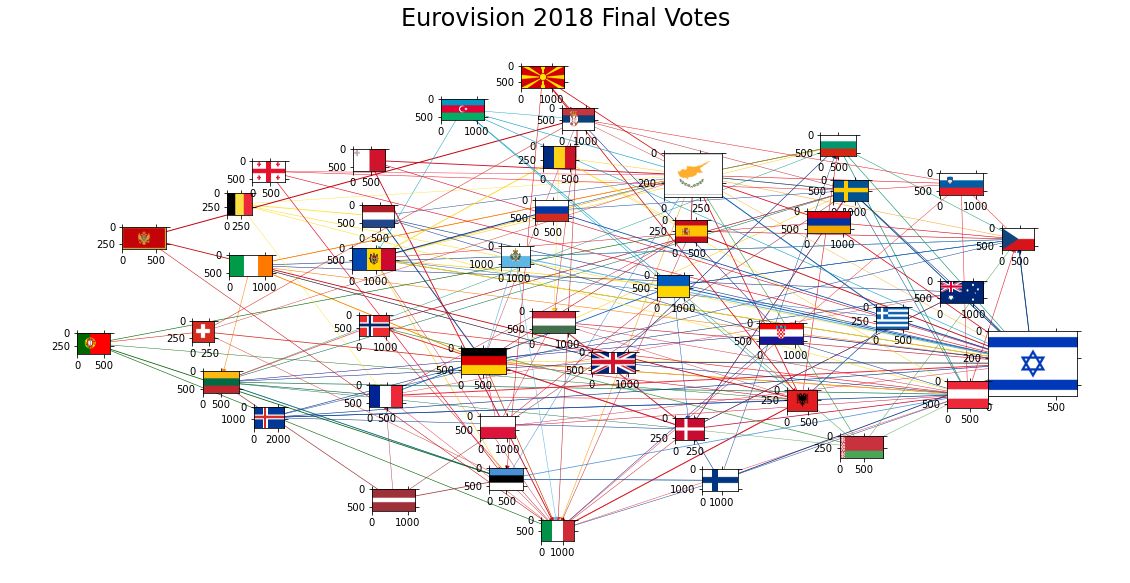

In [33]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

pos = nx.layout.fruchterman_reingold_layout(G,k=1,weight = 'points',iterations=1000,scale = 2)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform


tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params
styles = ['dotted','dashdot','dashed','solid'] # line styles



# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.4: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, 
                               style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():    
    imsize = max((0.3*G.in_degree(node,weight='points')/max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_spring.png')
    

## Possible additional exercises:
- communities detection
- centrality measures
- graph partition
- Year-of-year dynamics